In [1]:
from lbg_forecast.likelihood import Likelihood
import lbg_forecast.utils as utils

from lbg_forecast.angular_power import define_cosmo
from lbg_forecast.angular_power import pk
import lbg_forecast.angular_power as ap
from functools import partial

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax_cosmo as jc
import jax
from jax import jacfwd
from jax import jit

from uncertainties import unumpy as upy

In [24]:
def trig_plot(nparams, params, F, F_marg, F_extra=None, labels=None, colour='r', colour_extra='purple', fill=True, lw=2, alpha=0.3):
    
    plt.figure(figsize=(25, 30))

    #randnos = np.random.multivariate_normal(np.array([params[0], params[1]]),
    #                                         np.linalg.inv(F), 1000)
    for i in range(nparams):
        for j in range(nparams):
            if j<i:
                plt.subplot(nparams,nparams,i*nparams+j+1)
                plt.subplots_adjust(wspace=0, hspace=0)


                plt.grid(alpha=0.4, zorder=-1)

                utils.plot_contours(F, params, j, i, K=2.279, fill=fill,color='k', alpha=alpha, zorder=5, ls="--", lw=lw)
                utils.plot_contours(F, params, j, i, K=5.991, fill=fill,color='k',  alpha=alpha*0.5, zorder=5, ls="--", lw=lw)
                #plot_contours(F, params, j, i, K=9.210, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)
                    #plot_contours(F, params, j, i, K=11.618, fill=True,color='b',  alpha=0.3, zorder=5)

                utils.plot_contours(F_marg, params, j, i, K=2.279, fill=fill,color=colour, alpha=alpha, zorder=1, lw=lw)
                utils.plot_contours(F_marg, params, j, i, K=5.991, fill=fill,color=colour, alpha=alpha*0.5, zorder=1, lw=lw)
                    #plot_contours(F_marg, params, j, i, K=9.210, fill=True,color='r',  alpha=0.3, zorder=1)
                    #plot_contours(F_marg, params, j, i, K=11.618, fill=True,color='r', alpha=0.3, zorder=1)

                if(F_extra is not None):
                    utils.plot_contours(F_extra, params, j, i, K=2.279, fill=fill,color=colour_extra, alpha=alpha, zorder=1, lw=lw, ls='-.')
                    utils.plot_contours(F_extra, params, j, i, K=5.991, fill=fill,color=colour_extra, alpha=alpha*0.5, zorder=1, lw=lw, ls='-.')

                

                if(j == 0):
                    plt.ylabel(labels[i], fontsize = 32)

                if(i == nparams-1):
                    plt.xlabel(labels[j], fontsize = 32)

                plt.tick_params(axis="x", width = 2, labelsize=15)
                plt.tick_params(axis="y", width = 2, labelsize=15)

                if(i < nparams - 1):
                    plt.tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        labelbottom=False)
                    
                if(j > 0):
                    plt.tick_params(
                        axis='y',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        left=False,        # ticks along the bottom edge are off
                        labelleft=False)
                #plt.scatter(randnos[:,0], randnos[:, 1], c ='r', zorder=100, alpha=.5, s=10)

In [3]:
path = "./"
lhood = Likelihood(path)
lhood_int = Likelihood(path, noint=True)
lhood_intfix = Likelihood(path, fixint=True)
lhood_red = Likelihood(path, n_override='min')
lhood_max = Likelihood(path, n_override='max')

Initialising likelihood
Initialisation Complete
Initialising likelihood
Initialisation Complete
Initialising likelihood
Initialisation Complete
Initialising likelihood
Initialisation Complete
Initialising likelihood
Initialisation Complete


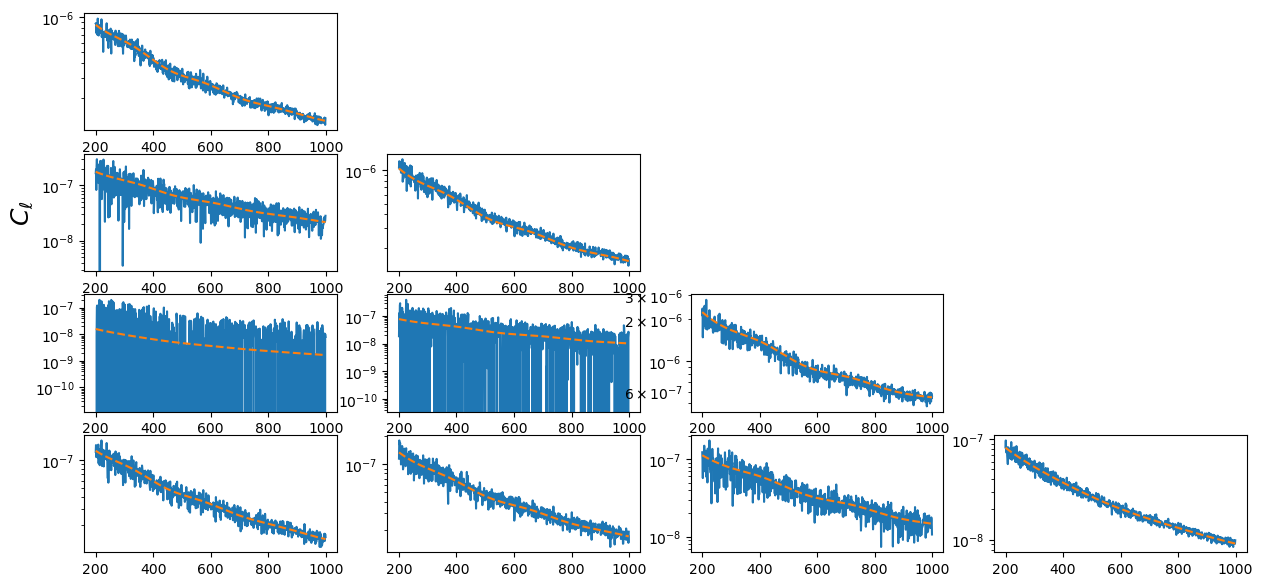

In [4]:
params = np.array([lhood._cosmo_fid.sigma8, 
                lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

params_mod = np.array([lhood._cosmo_fid.sigma8, 
                lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

ap.compare_cls(lhood.cl_mean, lhood.mu_vec(params_mod), lhood._ell, (15, 7), 18, 4)


In [5]:
def forecast_derived():
    o_m = lhood._cosmo_fid.Omega_c + lhood._cosmo_fid.Omega_b
    s8 = lhood._cosmo_fid.sigma8*np.sqrt(o_m/0.3)

    params = np.array([o_m, s8, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

    labels = np.array(["$\Omega_{m}$", "$S_{8}$","$\Omega_{b}$",
                        "$h$", "$n_{s}$", "$b^{lbg}_{u}$", "$b^{lbg}_{g}$", "$b^{lbg}_{r}$"])

    F = lhood.fisher_deriv(params)
    F_marg = lhood.fisher_marg_deriv(params)

    return F, F_marg, params, labels


In [6]:
def forecast(lhood):

    params = np.array([lhood._cosmo_fid.sigma8, 
                    lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

    labels = np.array(["$\sigma_{8}$", "$\Omega_{c}$", "$\Omega_{b}$",
                        "$h$", "$n_{s}$", "$b^{lbg}_{u}$", "$b^{lbg}_{g}$", "$b^{lbg}_{r}$"])

    F = lhood.fisher(params)
    F_marg = lhood.fisher_marg(params)

    return F, F_marg, params, labels

In [7]:
F_fixint, F_fixint_marg, params, labels = forecast(lhood_intfix)

In [8]:
F_noint, F_noint_marg, params, labels = forecast(lhood_int)

In [9]:
F, F_marg, params, labels = forecast(lhood)

In [10]:
F_red, F_red_marg, params, labels = forecast(lhood_red)

In [11]:
F_max, F_max_marg, params, labels = forecast(lhood_max)

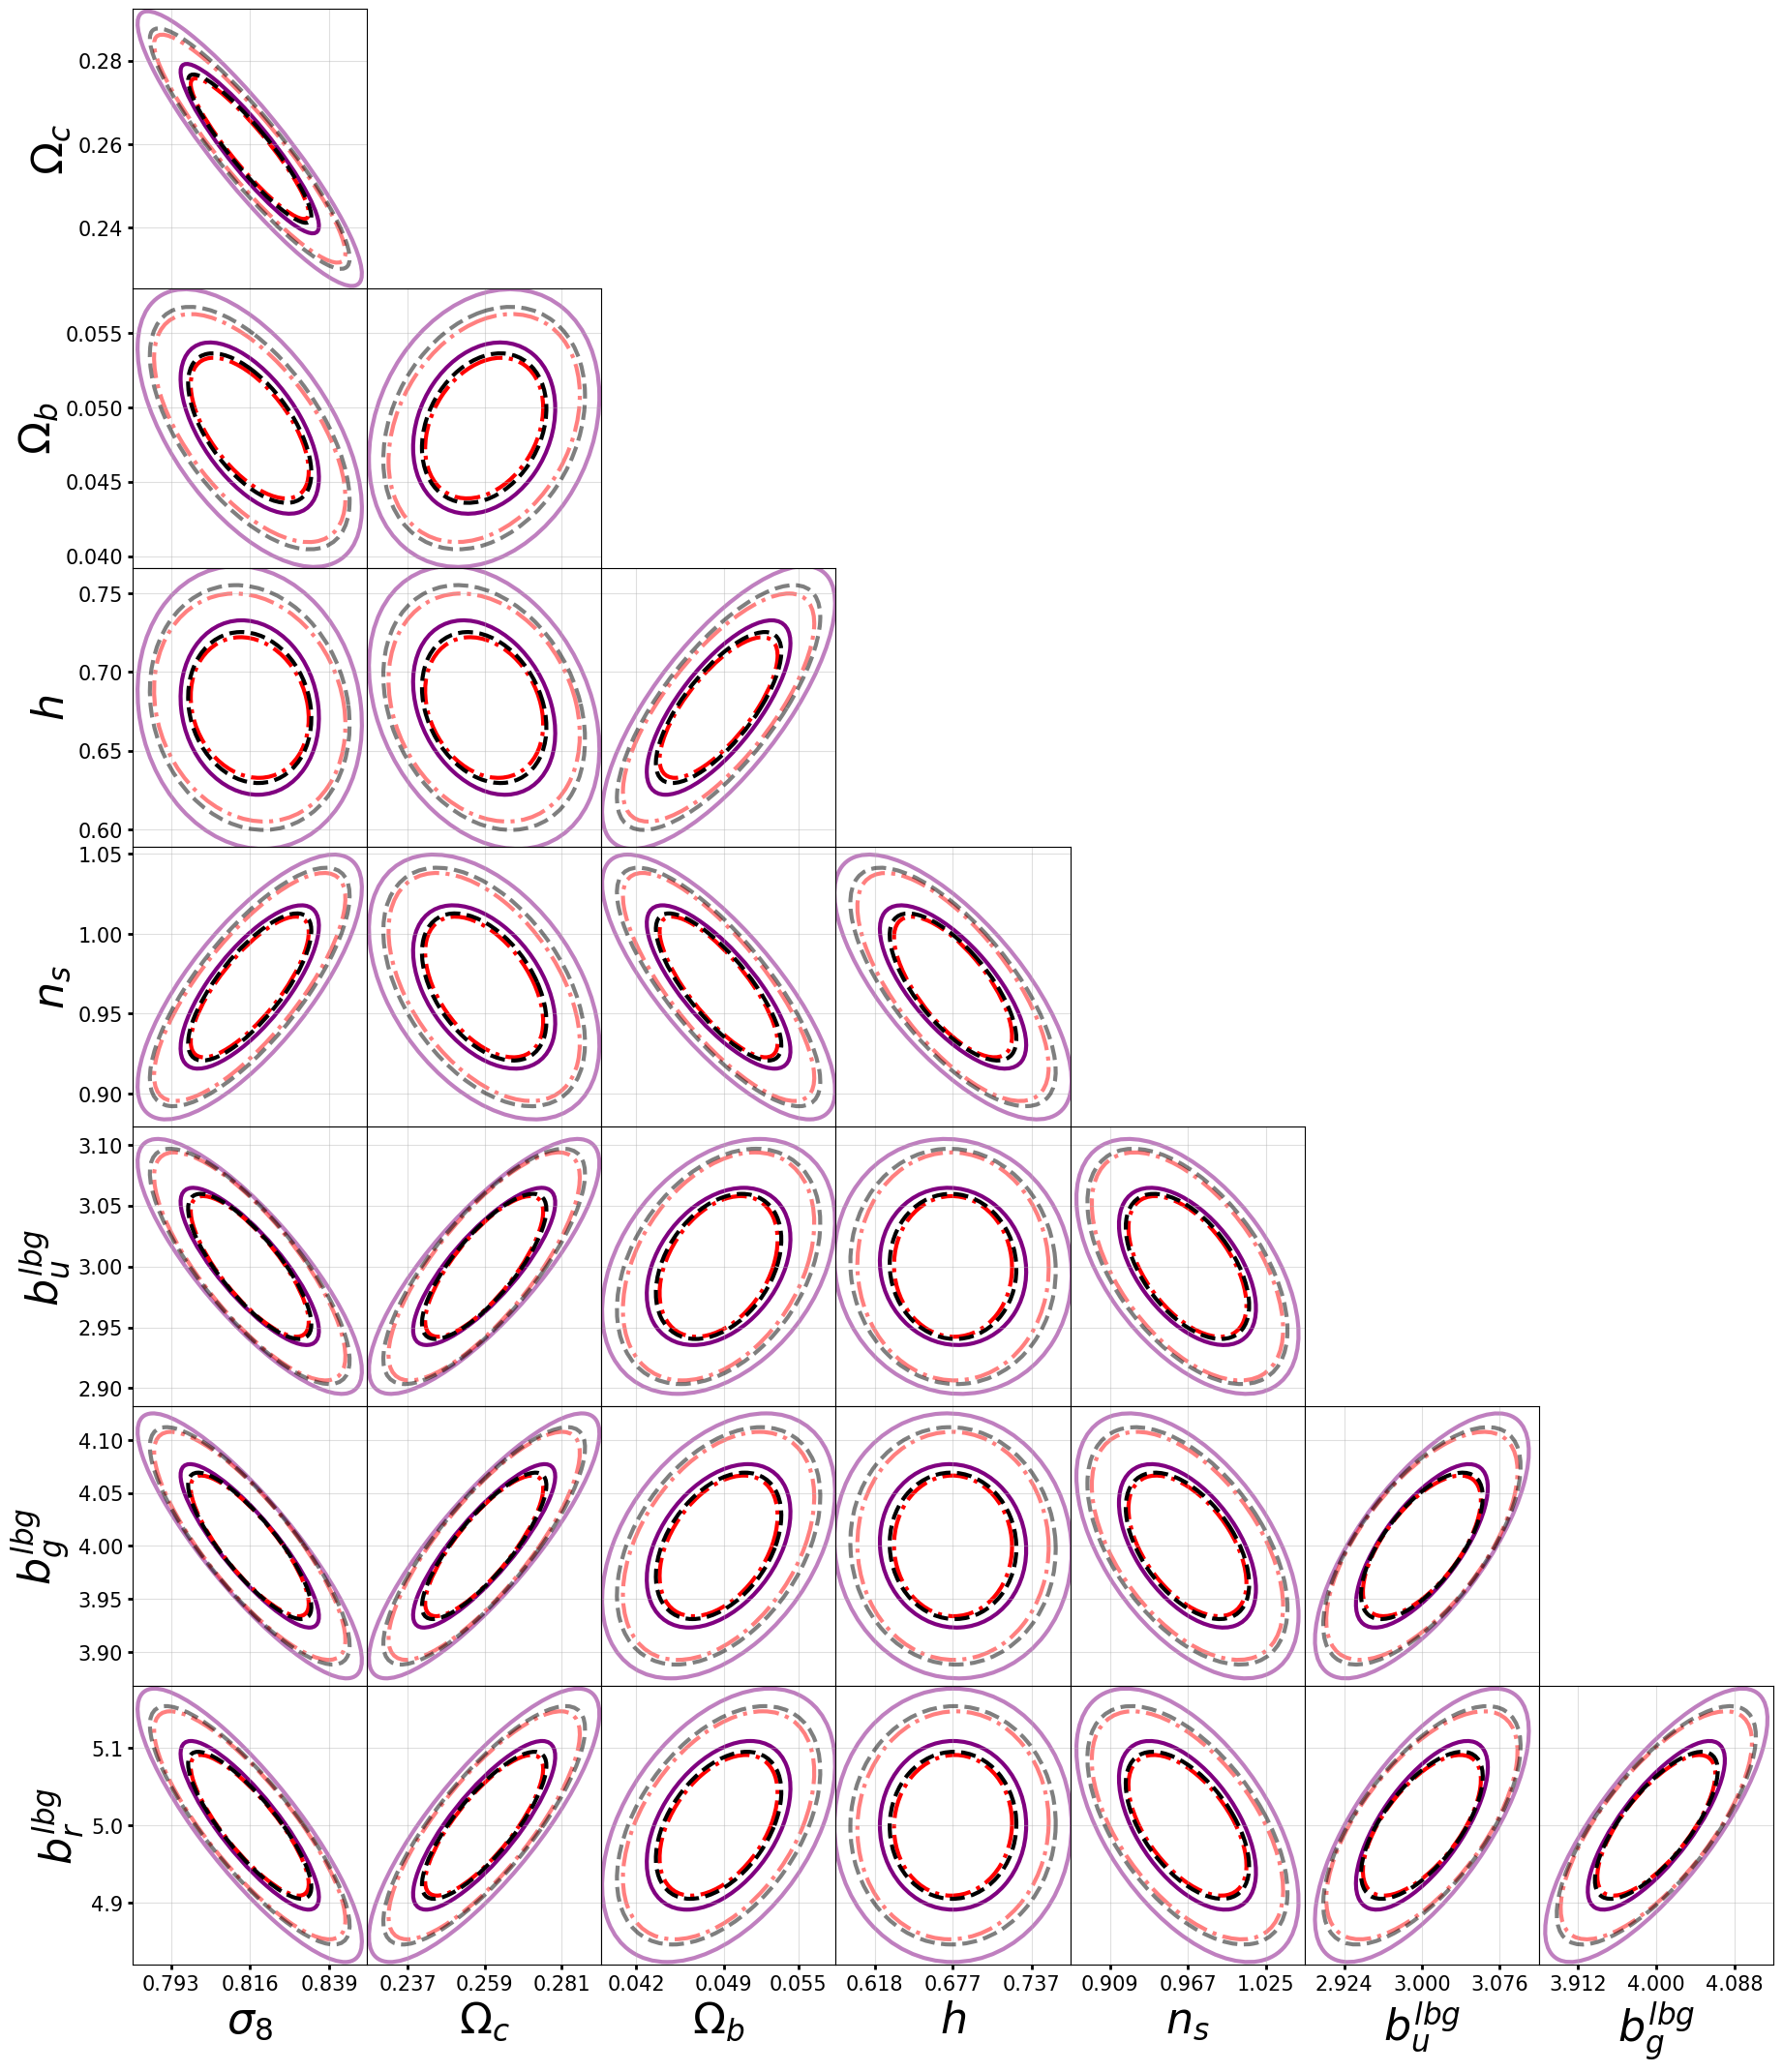

In [27]:
trig_plot(len(params), params, F_marg, F_red_marg, F_max_marg, labels=labels, colour='purple', colour_extra='red', fill=False, lw=3, alpha=1.0)

In [36]:
2*np.sqrt(np.linalg.inv(F_marg)[0, 0])/lhood._cosmo_fid.sigma8, 2*np.sqrt(np.linalg.inv(F_max_marg)[0, 0])/lhood._cosmo_fid.sigma8, 2*np.sqrt(np.linalg.inv(F_red_marg)[0, 0])/lhood._cosmo_fid.sigma8

(0.029111953634413216, 0.027876690393980285, 0.032685947901083715)

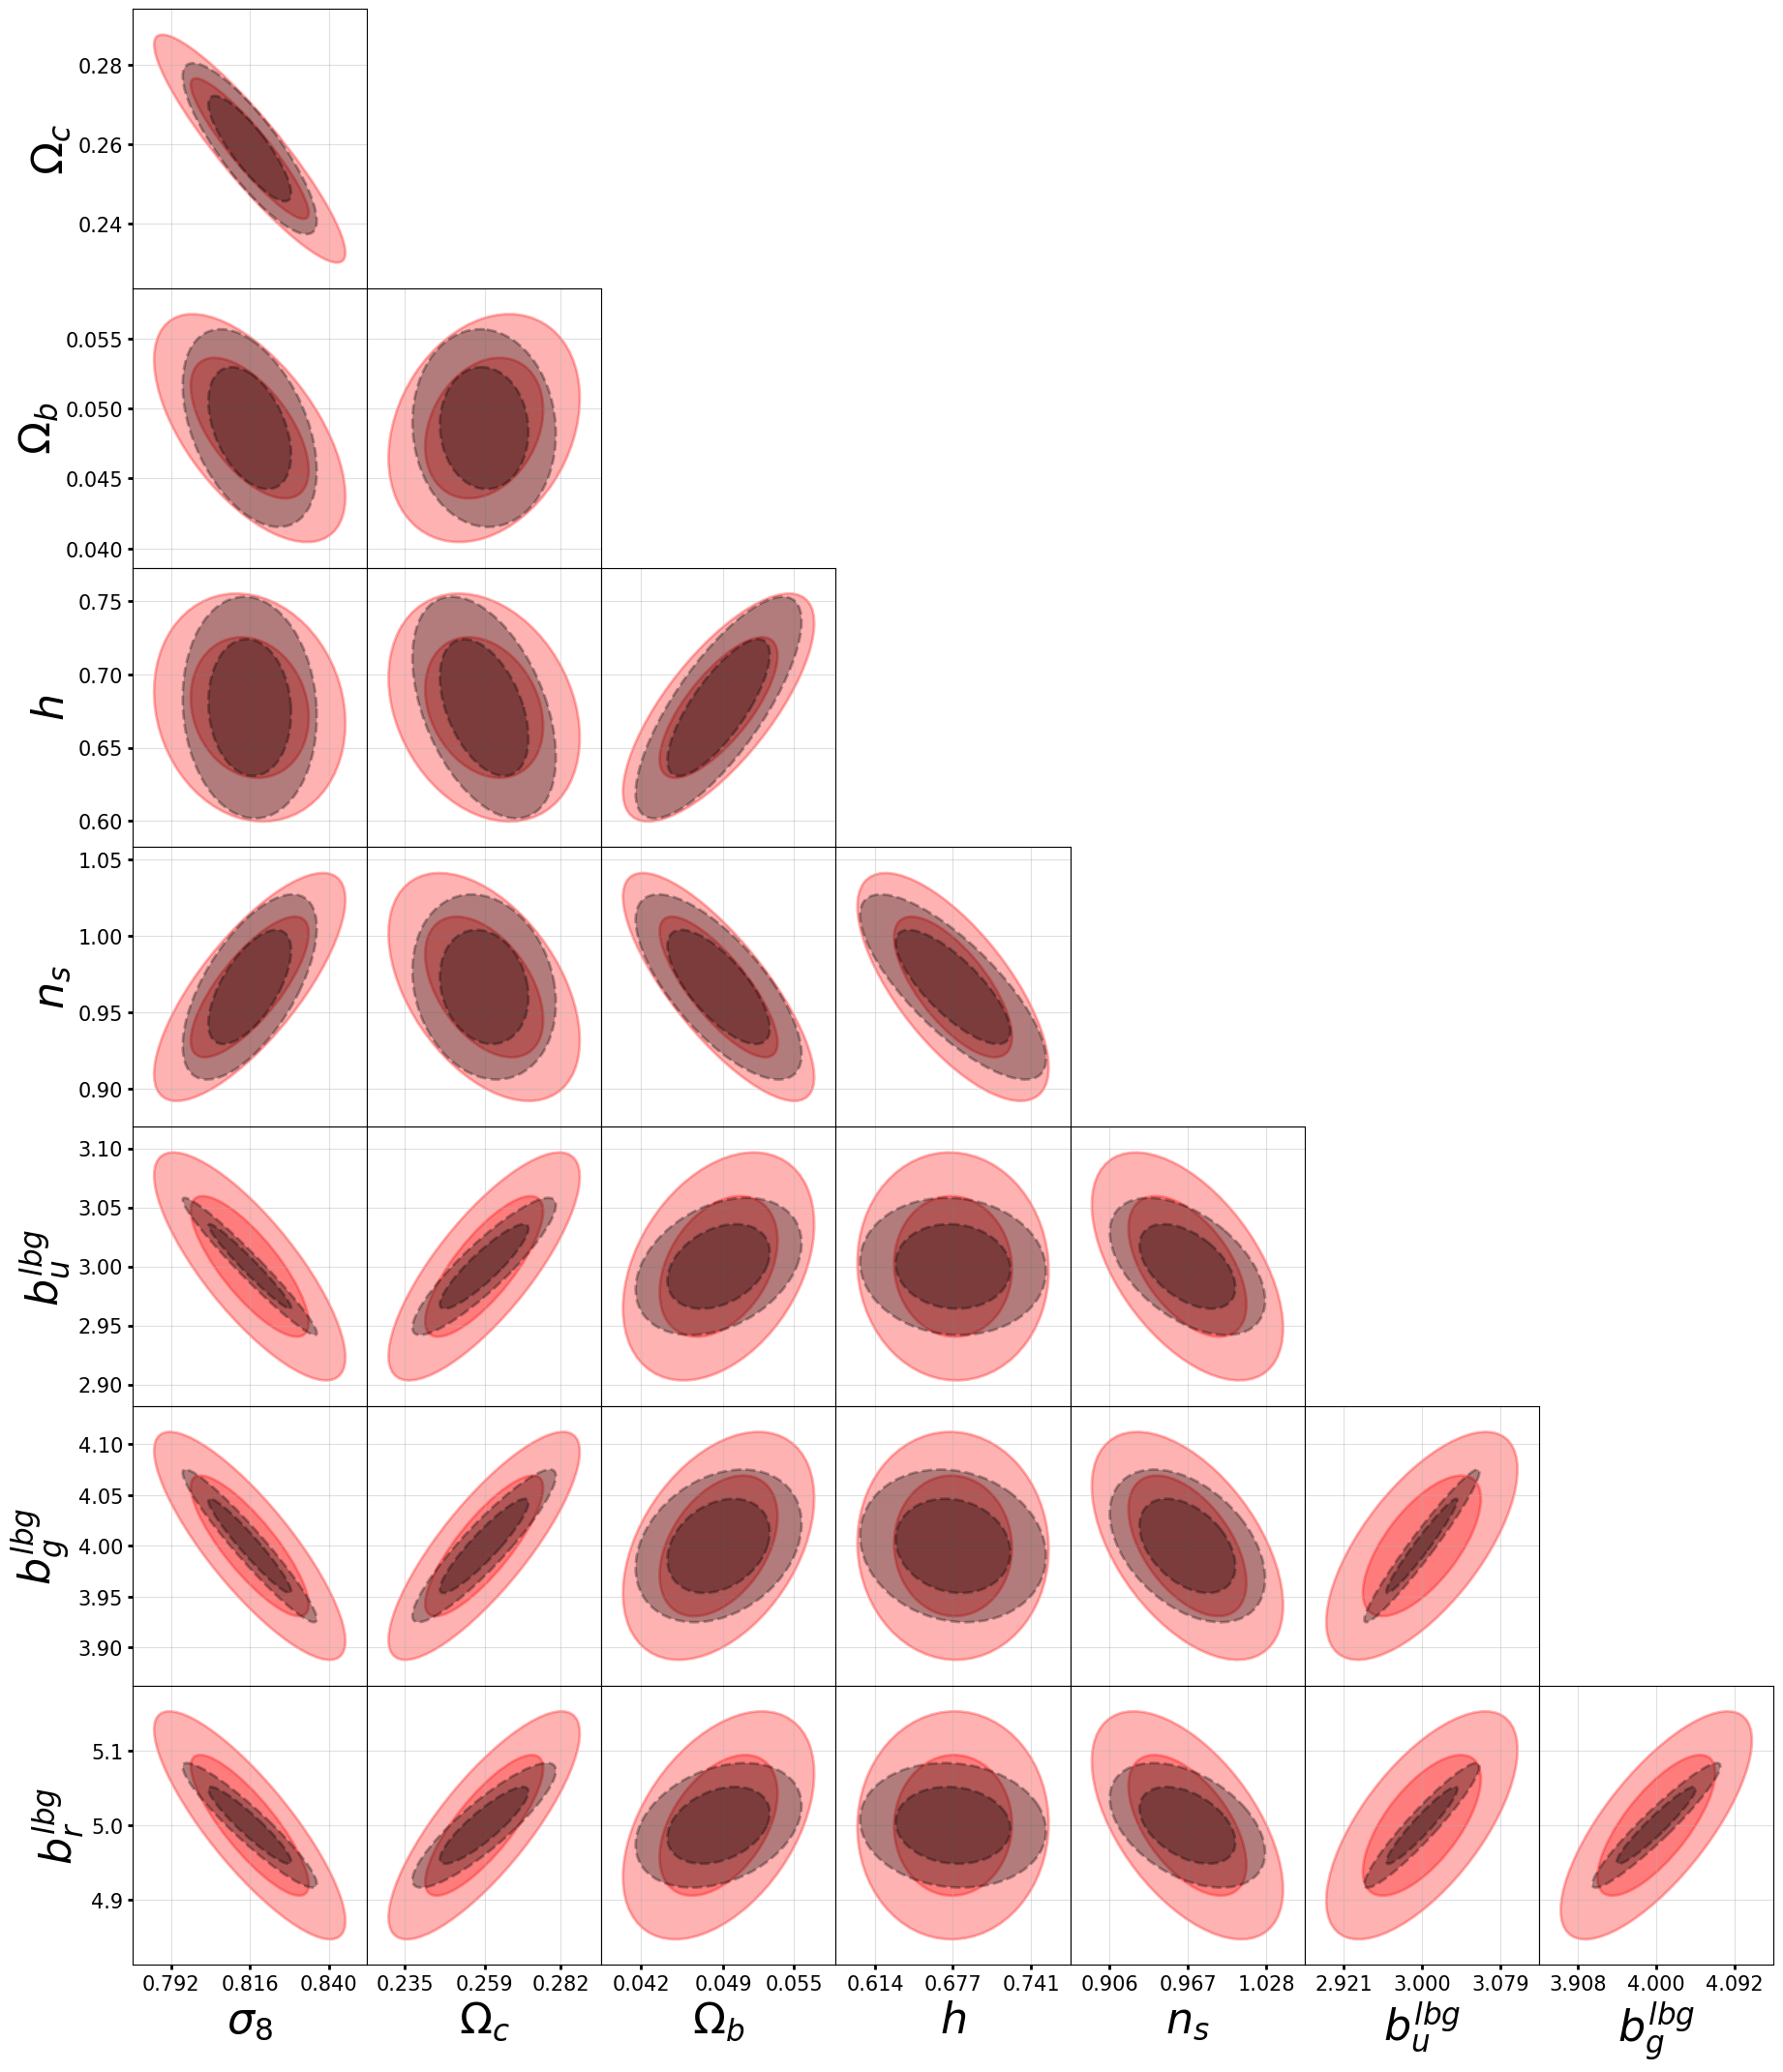

In [13]:
trig_plot(len(params), params, F, F_marg, labels)

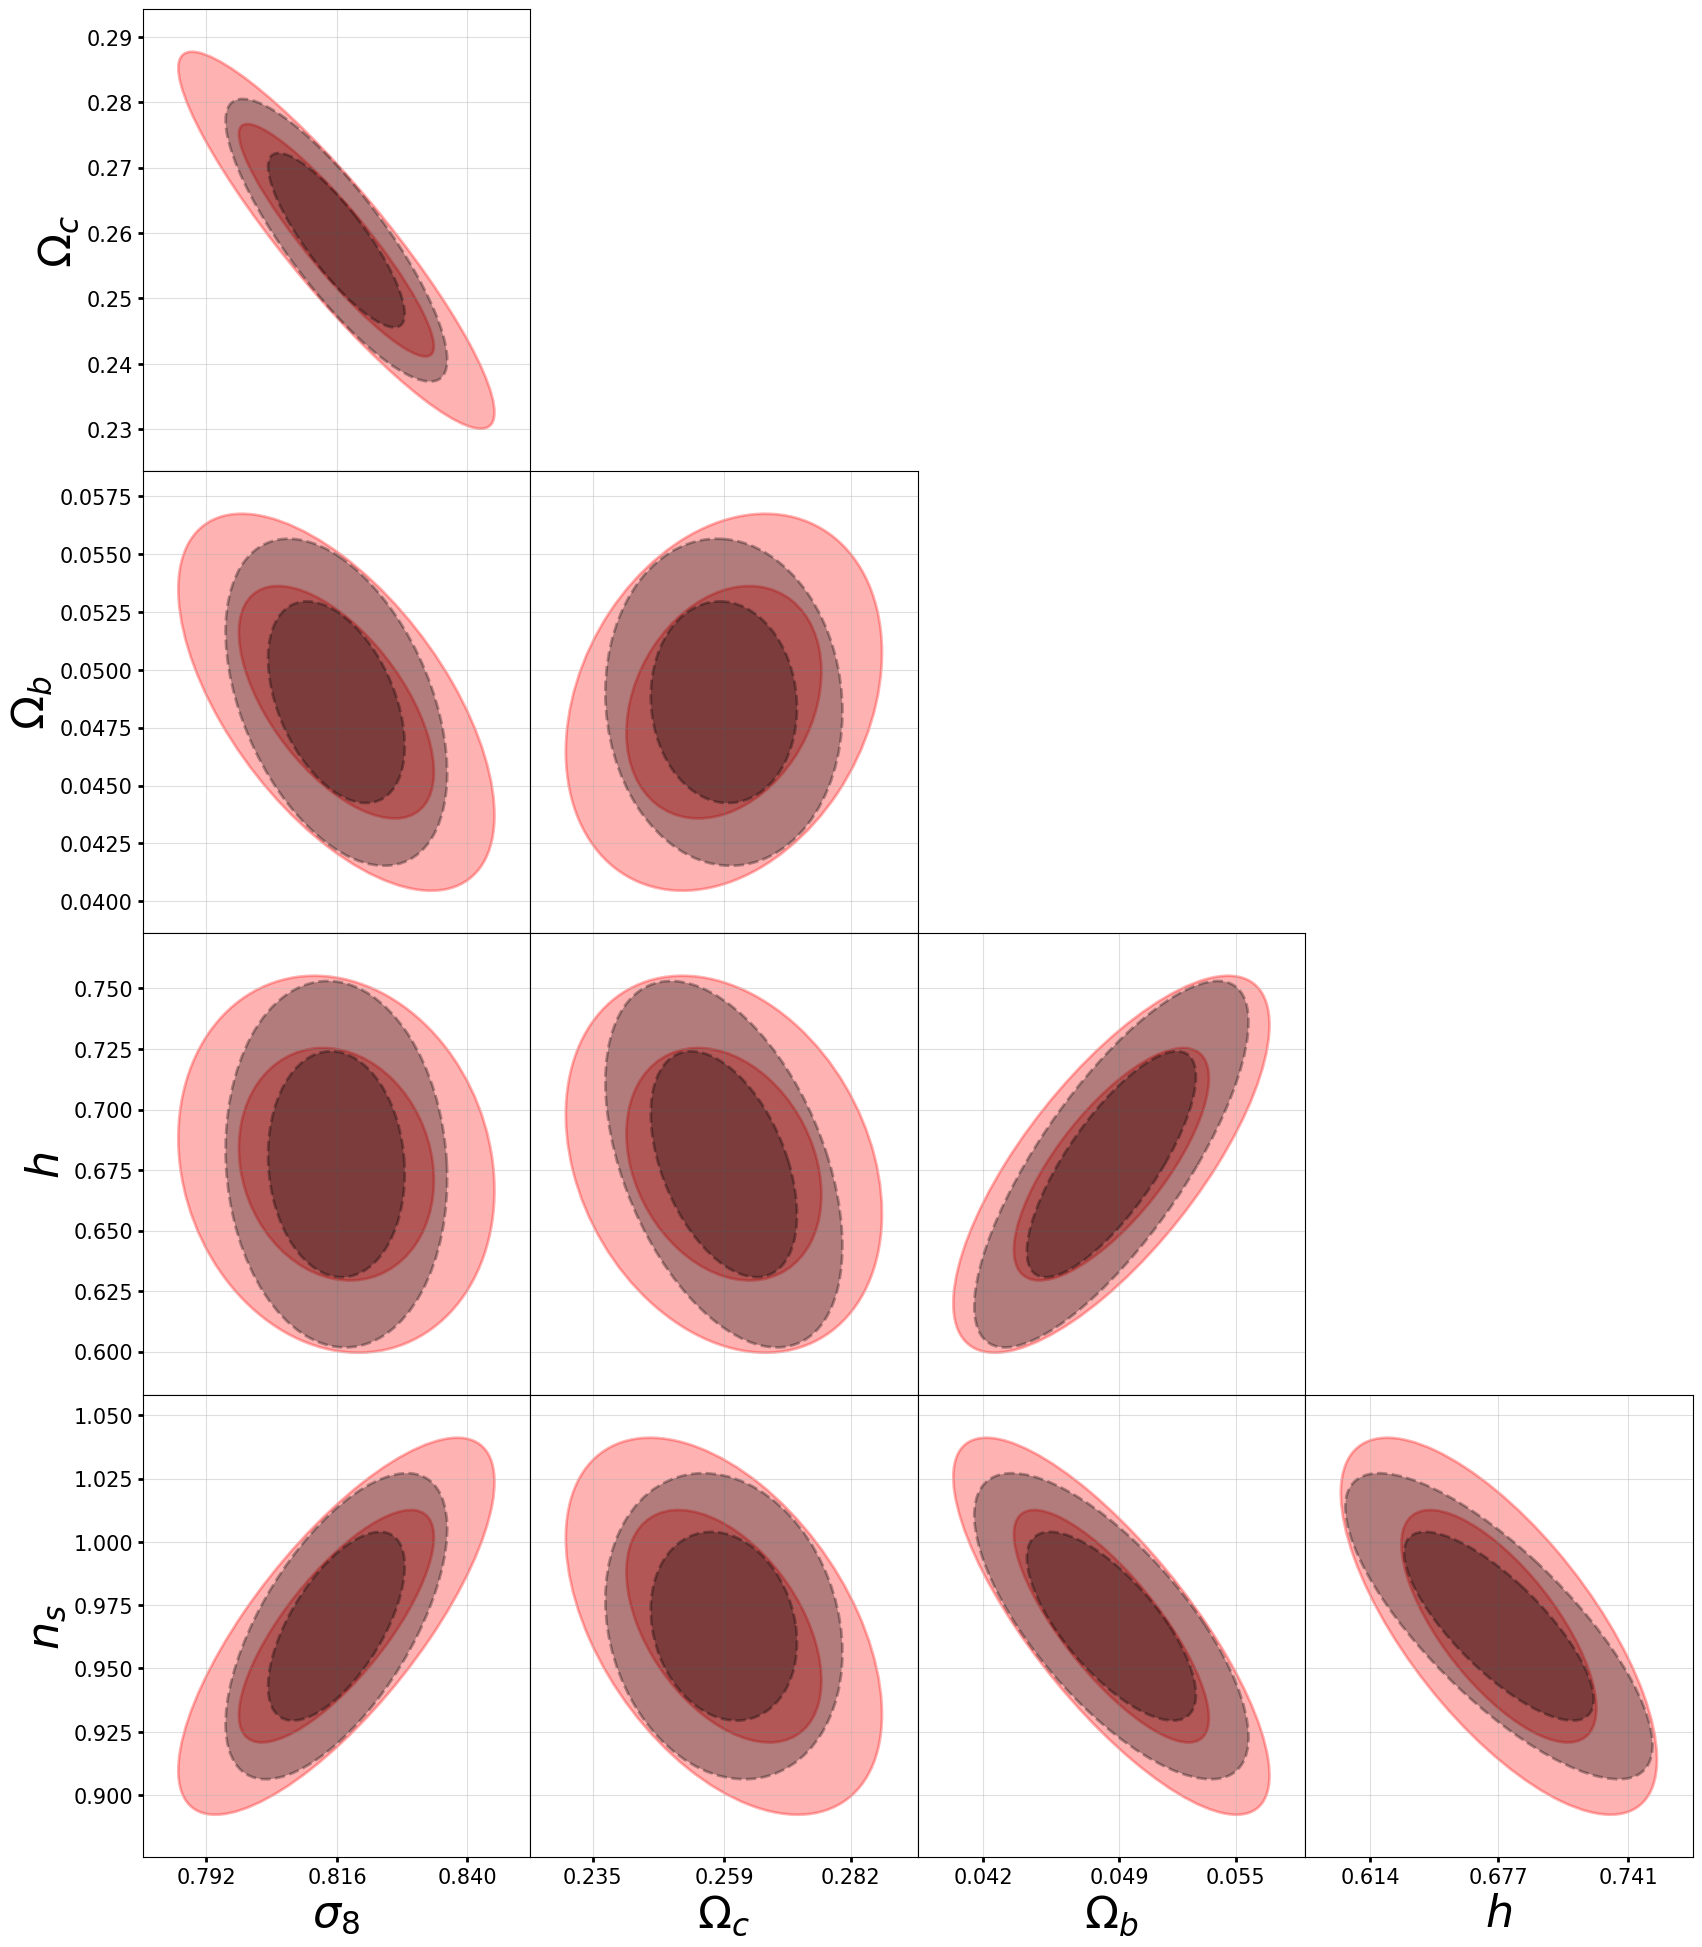

In [14]:
trig_plot(5, params, F, F_marg, labels)

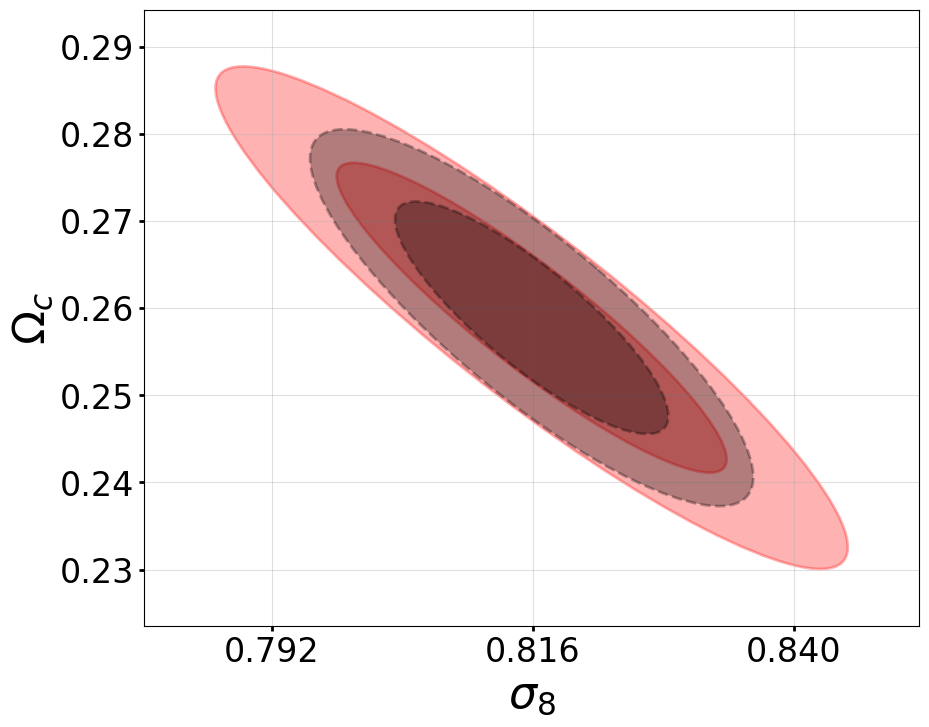

In [15]:
i = 1
j = 0
plt.figure(figsize=(10, 8))
plt.grid(alpha=0.4, zorder=-1)

utils.plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=5, ls="--", lw=2)
utils.plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)

utils.plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
utils.plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1, lw=2)

plt.ylabel(labels[i], fontsize = 32)
plt.xlabel(labels[j], fontsize = 32)

plt.tick_params(axis="x", width = 2, labelsize=24)
plt.tick_params(axis="y", width = 2, labelsize=24)


In [16]:
params_cosmo = jnp.array([lhood._cosmo_fid.sigma8, lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s])

def fisher_to_stds(fisher):
    return jnp.sqrt(jnp.diag(jnp.linalg.inv(fisher)))[:-3]

@jit #nonlinear vs linear power spectrum
def sigma8(params_cosmo, z):
    sigma8, Omega_c, Omega_b, h, n_s = params_cosmo 
    cosmo_obj = jc.Planck15(sigma8=sigma8, Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=n_s)
    return sigma8*jnp.sqrt(pk(cosmo_obj, 1/8, z)/pk(cosmo_obj, 1/8, 0.0))

@jit
def sigma8_error(params_cosmo, z, fisher):

    jacobian = jacfwd(sigma8, argnums=0)
    dfdx = jacobian(params_cosmo, z)
    stds = fisher_to_stds(fisher)
    prop_err = jnp.sqrt(jnp.sum(((dfdx)**2)*((stds)**2)))

    return prop_err

print(sigma8(params_cosmo, 0.0), sigma8_error(params_cosmo, 0.0, F_marg))
print(lhood._cosmo_fid.sigma8, fisher_to_stds(F_marg)[0])

0.8159 0.01187622148515887
0.8159 0.01187622148515887


In [17]:
sigma8_z = []
sigma8_z_error = []
z_space = jnp.linspace(0.0, 10.0, 20)
for z in z_space:
    sigma8_z.append(sigma8(params_cosmo, z))
    sigma8_z_error.append(sigma8_error(params_cosmo, z, F_marg))

sigma8_z = np.array(sigma8_z)
sigma8_z_error = np.array(sigma8_z_error)
z_space = np.array(z_space)

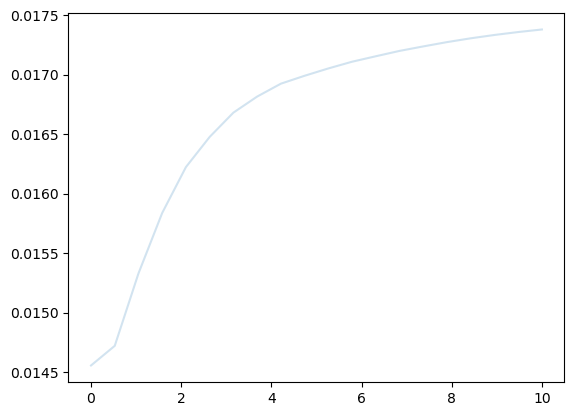

In [18]:
plt.plot(z_space, sigma8_z_error/sigma8_z, alpha=0.2)

In [19]:
F, F_marg, params, labels = forecast_derived()

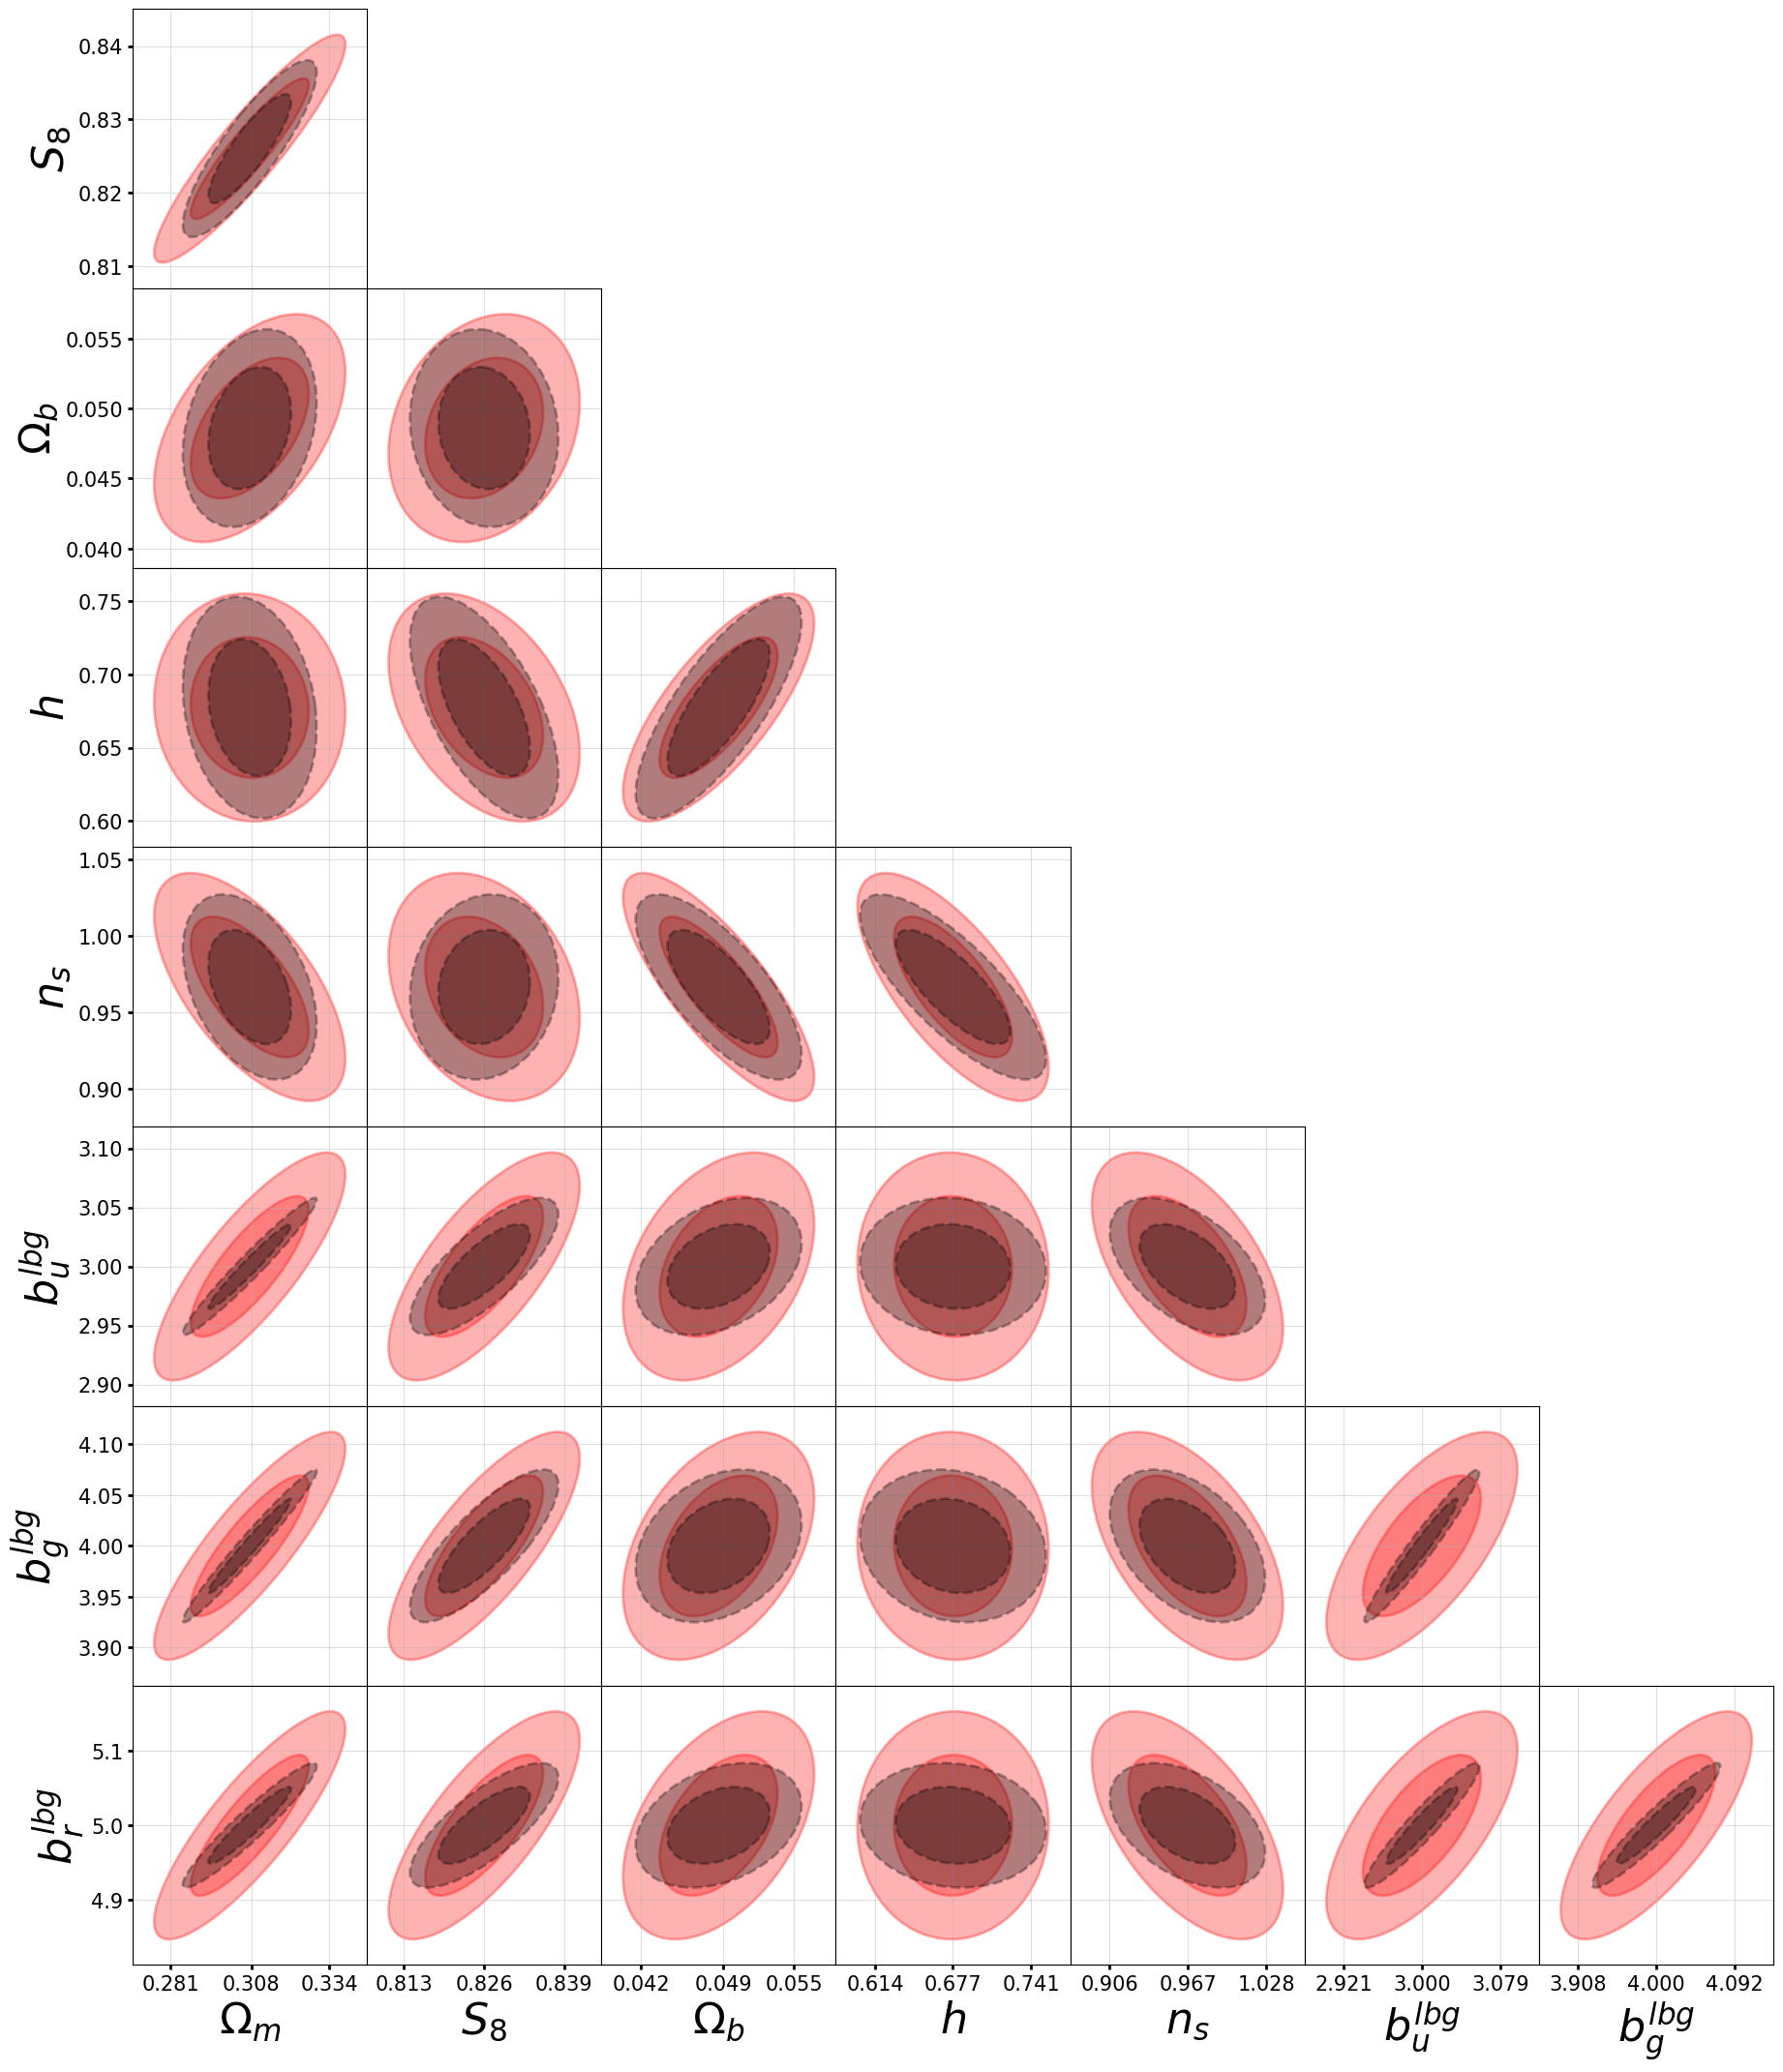

In [20]:
trig_plot(len(params), params, F, F_marg, labels)

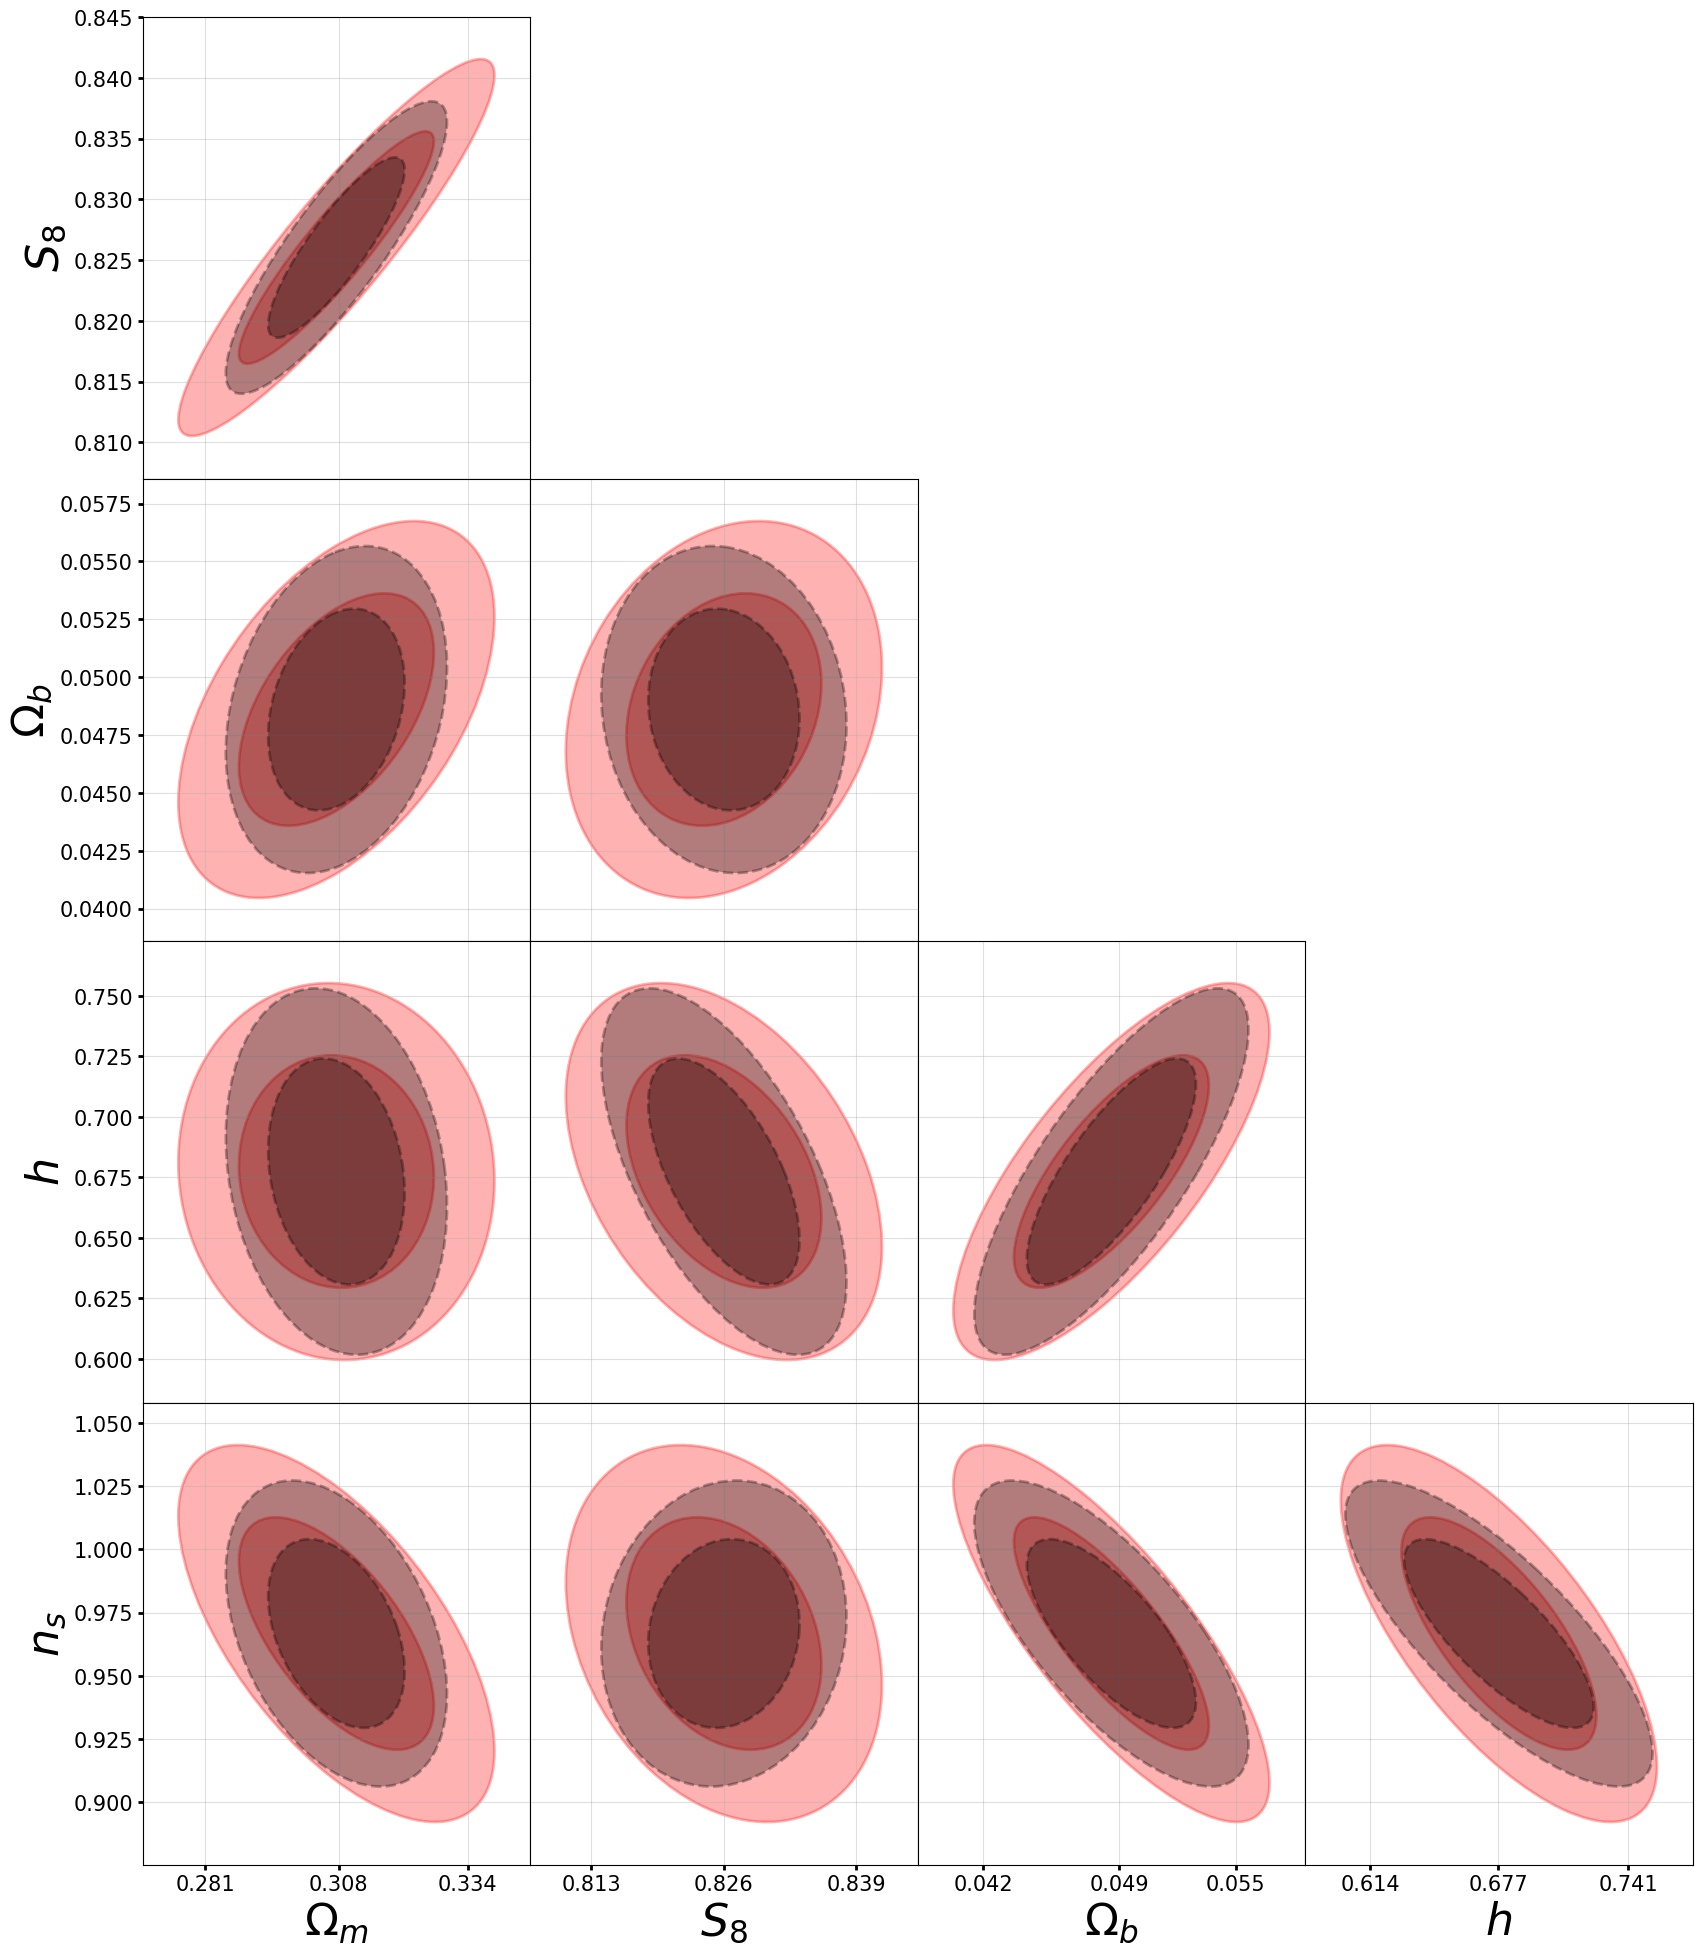

In [21]:
trig_plot(5, params, F, F_marg, labels)

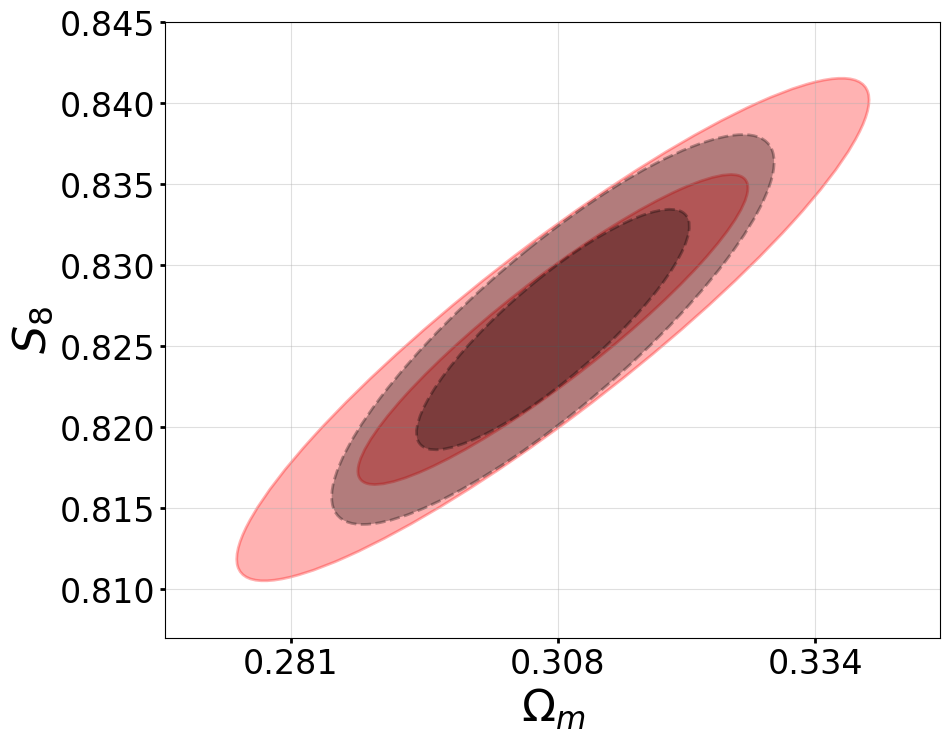

In [22]:
i = 1
j = 0
plt.figure(figsize=(10, 8))
plt.grid(alpha=0.4, zorder=-1)

utils.plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=5, ls="--", lw=2)
utils.plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)

utils.plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
utils.plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1, lw=2)

plt.ylabel(labels[i], fontsize = 32)
plt.xlabel(labels[j], fontsize = 32)

plt.tick_params(axis="x", width = 2, labelsize=24)
plt.tick_params(axis="y", width = 2, labelsize=24)

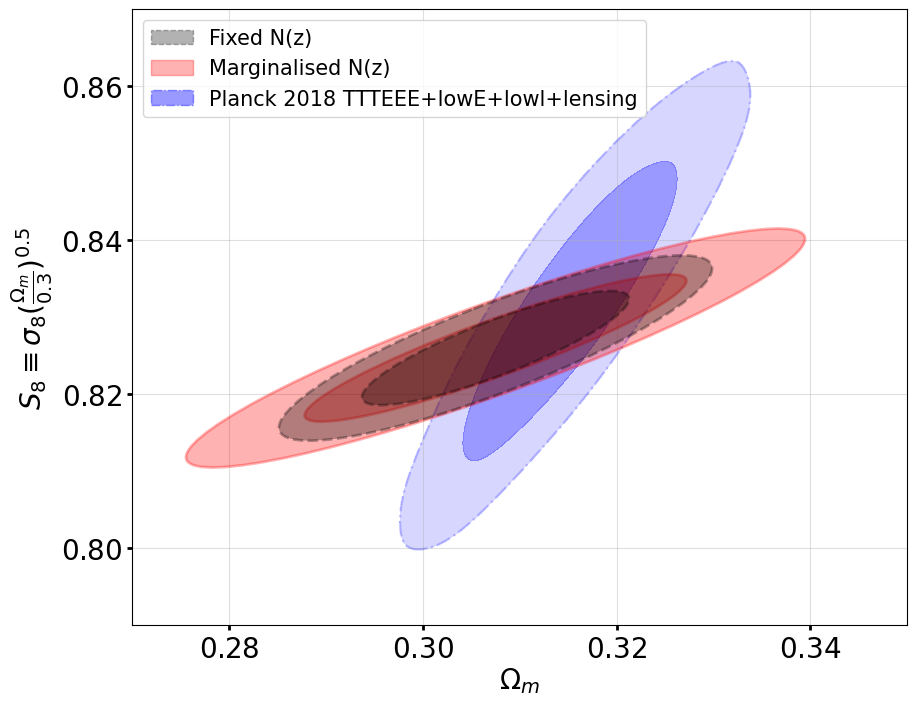

<Figure size 600x450 with 0 Axes>

In [23]:
from getdist import plots
from getdist import MCSamples

from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='k', edgecolor='k', label='Fixed N(z)', linestyle='--', alpha=0.3),
                   Patch(facecolor='r', edgecolor='r', label='Marginalised N(z)', linestyle='-', alpha=0.3),
                   Patch(facecolor='b', edgecolor='b', label='Planck 2018 TTTEEE+lowE+lowl+lensing',linestyle='-.', alpha=0.4)]

i = 1
j = 0
f, ax = plt.subplots(1, 1, figsize=(10, 8))

utils.plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=500, ls="--", lw=2, label='Fixed N(z)')
utils.plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=500, ls="--", lw=2)

utils.plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=100, ls='-', lw=2)
utils.plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=100, ls='-', lw=2,  label='Marginalised')

g=plots.get_single_plotter(chain_dir=r'/Users/fpetri/Desktop/planck_data_full/base/plikHM_TTTEEE_lowl_lowE_lensing')
roots = ['base_plikHM_TTTEEE_lowl_lowE_lensing']
pairs = ['omegam', 'S8']
g.plot_2d(roots, 'omegam', 'S8', filled=True, shaded=False, ax=ax, alphas=0.4, ls='-.', lws=1, colors=['blue'])

ax.grid(alpha=0.4, zorder=-100)

ax.set_xlim(0.27, 0.35)
ax.set_ylim(0.79, 0.87)

ax.set_ylabel('$S_{8} \equiv \sigma_{8}(\\frac{\Omega_{m}}{0.3})^{0.5}$', fontsize = 20)
ax.set_xlabel(labels[j], fontsize = 20)

ax.tick_params(axis="x", width = 2, labelsize=20)
ax.tick_params(axis="y", width = 2, labelsize=20)

ax.legend(handles=legend_elements, loc='upper left', fontsize=15)